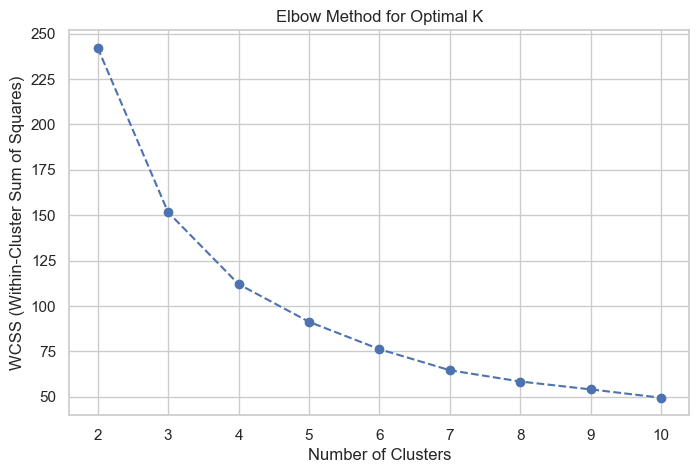

Davies-Bouldin Index: 0.8651
Silhouette Score: 0.3736
Cluster Analysis:
        Total_Spent                     Transaction_Count         \
               mean   median        sum              mean median   
Cluster                                                            
0           6263.45  6088.50  187903.42              8.43    8.0   
1           1273.37  1179.29   56028.20              2.36    3.0   
2           2982.41  2933.12  226662.91              4.39    4.0   
3           4477.57  4565.57  219401.03              6.31    6.0   

        Total_Quantity         
                  mean median  
Cluster                        
0                23.00   22.0  
1                 5.27    5.5  
2                10.87   11.0  
3                16.10   16.0  


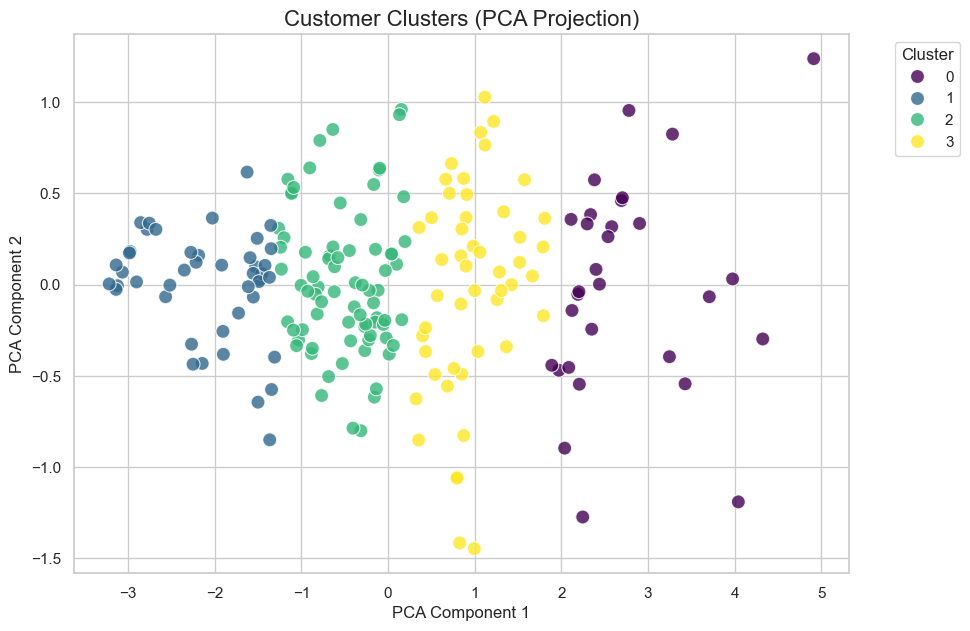

Cluster results saved to: ../outputs/FirstName_LastName_Clustering.csv


In [2]:
# Customer_Segmentation.ipynb - Customer Clustering

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load datasets
customers = pd.read_csv('../data/Customers.csv')
transactions = pd.read_csv('../data/Transactions.csv')
products = pd.read_csv('../data/Products.csv')

# Merge datasets
df = transactions.merge(customers, on='CustomerID', how='left') \
               .merge(products, on='ProductID', how='left')

# Feature engineering
customer_features = df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'nunique',
    'Quantity': 'sum'
}).reset_index()

# Rename columns for better clarity
customer_features.rename(columns={
    'TotalValue': 'Total_Spent',
    'TransactionID': 'Transaction_Count',
    'Quantity': 'Total_Quantity'
}, inplace=True)

# Scale data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:])

# Determine optimal number of clusters using Elbow Method
wcss = []
k_range = range(2, 11)  # Between 2 and 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# Apply KMeans clustering with optimal clusters (e.g., k=4 based on elbow method)
optimal_k = 4  # Replace with the optimal K determined visually
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, kmeans_labels)
silhouette_avg = silhouette_score(scaled_features, kmeans_labels)
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Add cluster labels to dataframe
customer_features['Cluster'] = kmeans_labels

# Analyze cluster characteristics
cluster_analysis = customer_features.groupby('Cluster').agg({
    'Total_Spent': ['mean', 'median', 'sum'],
    'Transaction_Count': ['mean', 'median'],
    'Total_Quantity': ['mean', 'median']
}).round(2)

print("Cluster Analysis:")
print(cluster_analysis)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=customer_features['PCA1'], y=customer_features['PCA2'], 
    hue=customer_features['Cluster'], palette='viridis', s=100, alpha=0.8
)
plt.title('Customer Clusters (PCA Projection)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Save cluster results
output_path = '../outputs/FirstName_LastName_Clustering.csv'
customer_features.to_csv(output_path, index=False)

print(f"Cluster results saved to: {output_path}")
